## Loading Packages


In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt 
from PIL import ImageFont, ImageDraw
import numpy as np
import argparse
import time
import cv2
import imutils

## Loading the FCN frozen Model


In [2]:
net = cv2.dnn.readNet("/content/drive/MyDrive/Thesis-Tire DOT Code/tire_dot_code_prediction.pb")

## Loading Test Tire Image

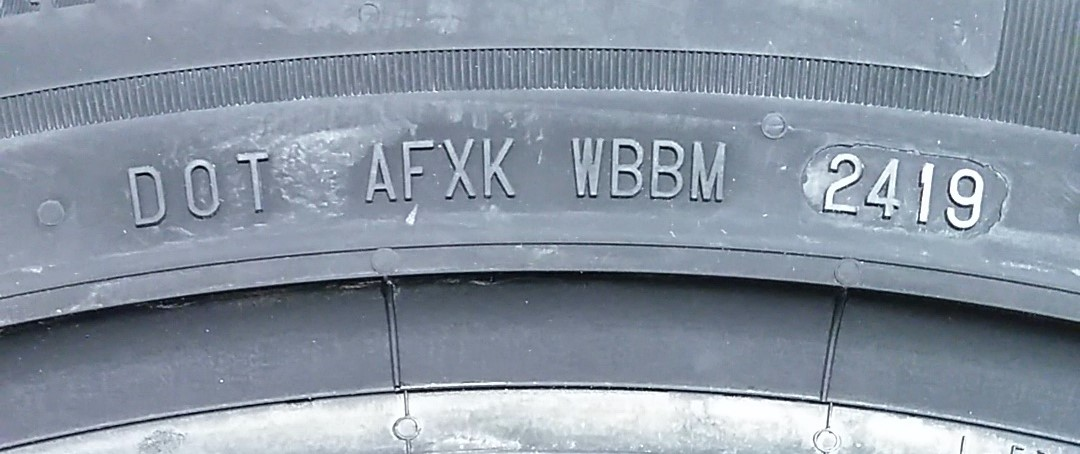

In [23]:
image = cv2.imread("/content/drive/MyDrive/Thesis-Tire DOT Code/test images/test1.jpeg")

# image height and width should be multiple of 32
imgWidth=320
imgHeight=320

orig = image.copy()
(H, W) = image.shape[:2]
(newW, newH) = (imgWidth, imgHeight)

rW = W / float(newW)
rH = H / float(newH)
image = cv2.resize(image, (newW, newH))

(H, W) = image.shape[:2]
cv2_imshow(orig)
     

## Pre-Processing

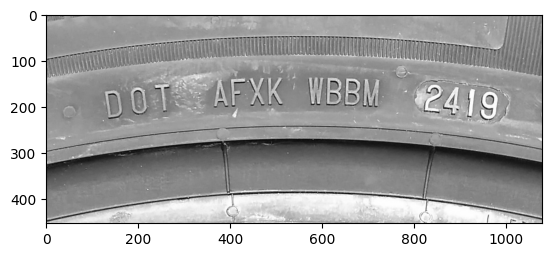

In [24]:
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

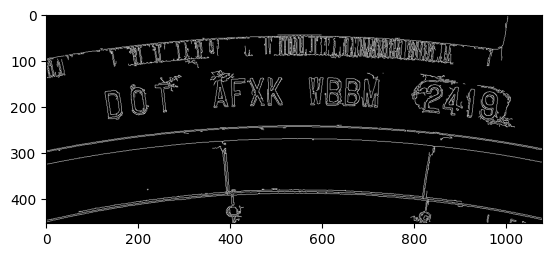

In [25]:
#bilateralFilter
bfilter = cv2.bilateralFilter(orig, 17, 21, 75)
# #denoising
dst = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
# #morphologicalgradient
kernel = np.ones((2,2),np.uint8)
gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
# #dilation
dilation = cv2.dilate(image,kernel,iterations = 1)
# #erosion
erosion = cv2.erode(gray,kernel,iterations = 1)
# #Gaussianblur
gblur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
# #Laplacianedge
edges = cv2.Laplacian(bfilter, -2, ksize=5, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
# #negativefilter
colored_negative = abs(255-bfilter)
# #cannyedgedetection
edged = cv2.Canny(bfilter, 10, 600) 

plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(dilation, cv2.COLOR_BGR2RGB))
# plt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))

## Creating Blob for Storing, Processing and Visualizing Data

In [26]:
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)

## Extracting the output feature maps of two layers

In [27]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

In [28]:
net.setInput(blob)
output = net.forward(outputLayers)
scores = output[0]
geometry = output[1]

## Contour Detection

In [29]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [30]:
location = None
for contour in contours:
  approx = cv2.approxPolyDP(contour, 10, True)
  if len(approx) == 4:
    location = approx
    break

## Creating Bounding Box for Text on Tires

In [31]:
def predictions(scores, geometry):
  (numRows, numCols) = scores.shape[2:4]
  rects = []
  confidences = []

  for y in range(0, numRows):
      scoresData = scores[0, 0, y]
      xData0 = geometry[0, 0, y]
      xData1 = geometry[0, 1, y]
      xData2 = geometry[0, 2, y]
      xData3 = geometry[0, 3, y]
      anglesData = geometry[0, 4, y]

      for x in range(0, numCols):
         # if our score does not have sufficient probability, ignore it
          if scoresData[x] < 0.5:
              continue

          # compute the offset factor as our resulting feature maps will
          # be 4x smaller than the input image
          (offsetX, offsetY) = (x * 4.0, y * 4.0)

          # extract the rotation angle for the prediction and then
          # compute the sin and cosine
          angle = anglesData[x]
          cos = np.cos(angle)
          sin = np.sin(angle)

          # use the geometry volume to derive the width and height of
          # the bounding box
          h = xData0[x] + xData2[x]
          w = xData1[x] + xData3[x]

          # compute both the starting and ending (x, y)-coordinates for
          # the text prediction bounding box
          endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
          endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
          startX = int(endX - w)
          startY = int(endY - h)

          # add the bounding box coordinates and probability score to
          # our respective lists
          rects.append((startX, startY, endX, endY))
          confidences.append(scoresData[x])
  return (rects, confidences)

## Applying Non-Max-Suppression

In [32]:

# Find predictions and  apply non-maxima suppression
(rects, confidences) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)
print(boxes)

[[236 112 290 164]
 [122  96 158 136]
 [170 103 200 141]
 [ 42 108  84 161]]


## Applying Mask to focus only the text area

In [33]:
mask = np.zeros(gray.shape, np.uint8)
new_img = cv2.drawContours(mask, [location], 0,255,2000)
new_img = cv2.bitwise_and(orig, orig, mask=mask)


In [34]:
(x,y) = np.where(mask==255)
(x1,y1) = (np.min(x), np.min(y))
(x2,y2) = (np.max(x), np.max(y))
orig = bfilter[x1:x2+1, y1:y2+1]

In [35]:
orig

array([[[195, 176, 164],
        [214, 194, 183],
        [194, 174, 162],
        ...,
        [167, 150, 134],
        [157, 140, 124],
        [156, 138, 123]],

       [[195, 175, 163],
        [216, 196, 184],
        [193, 173, 162],
        ...,
        [159, 142, 126],
        [153, 136, 120],
        [153, 136, 120]],

       [[201, 181, 170],
        [216, 196, 185],
        [180, 161, 147],
        ...,
        [155, 138, 122],
        [152, 135, 119],
        [153, 136, 120]],

       ...,

       [[113,  99,  91],
        [130, 117, 109],
        [151, 136, 129],
        ...,
        [210, 194, 177],
        [207, 192, 174],
        [206, 191, 173]],

       [[192, 177, 170],
        [204, 191, 184],
        [213, 200, 193],
        ...,
        [211, 195, 179],
        [207, 191, 174],
        [205, 189, 171]],

       [[215, 203, 195],
        [221, 209, 201],
        [227, 215, 208],
        ...,
        [210, 194, 178],
        [206, 191, 173],
        [204, 189, 171]]

## Text Detection Output

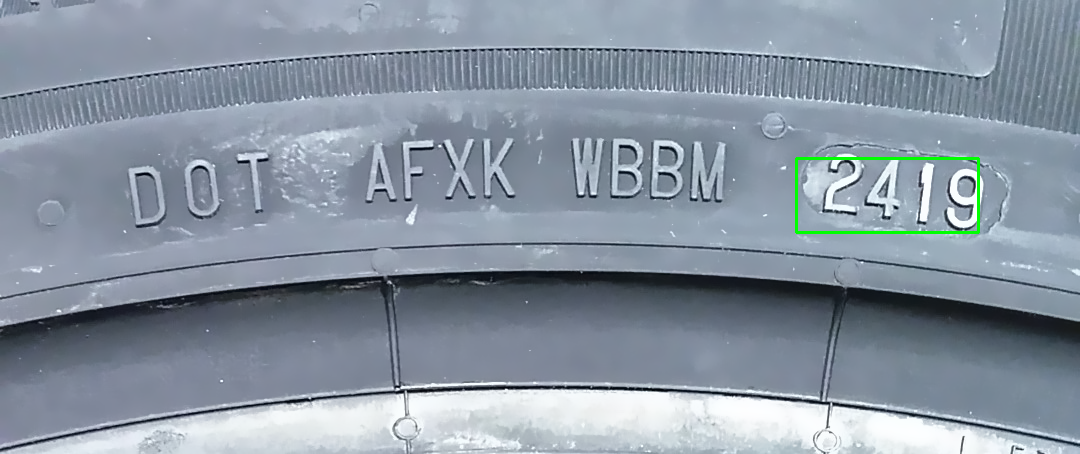

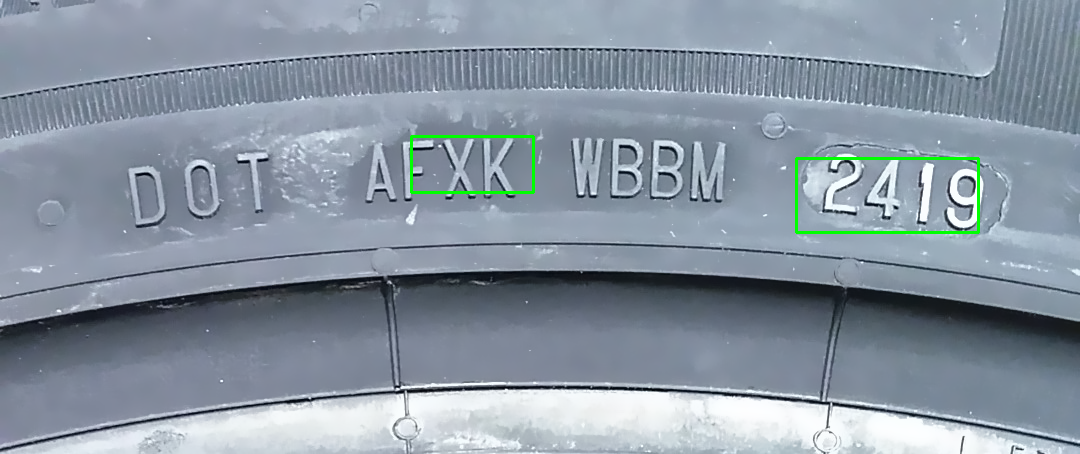

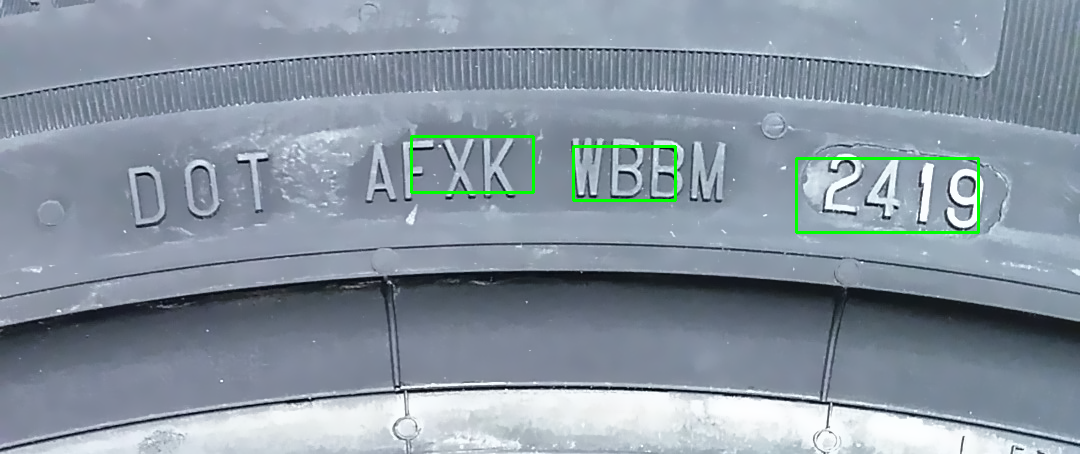

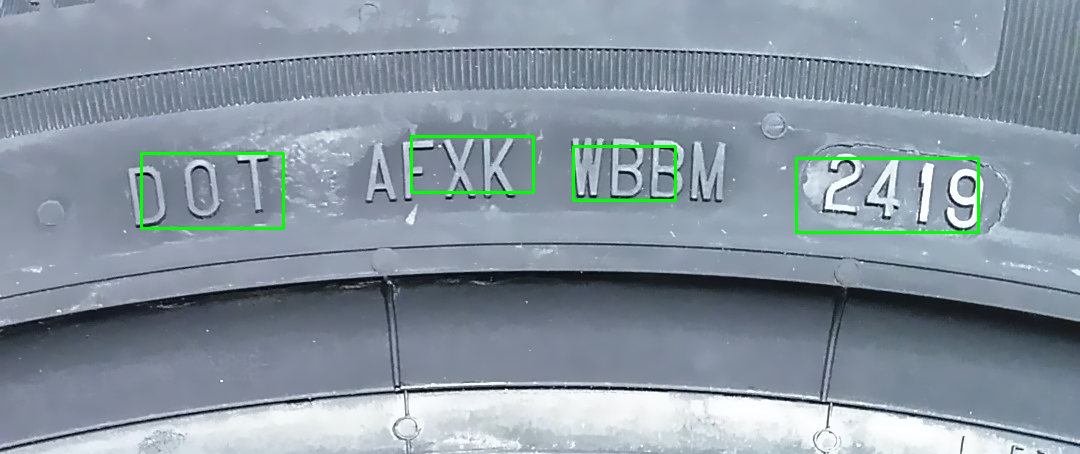

In [36]:


# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
  	
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    cv2_imshow(orig)

# # show the output image
# cv2_imshow(orig)
     

## Predicting detected bounding box characters from contours using EasyOCR

In [37]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
    import easyocr
    reader = easyocr.Reader(['en'], verbose=False)
    result = reader.readtext(orig)


In [39]:
result

[([[133, 145], [278, 145], [278, 230], [133, 230]],
  'D 0 T',
  0.5680956444766257),
 ([[396, 128], [528, 128], [528, 202], [396, 202]], 'FYK', 0.856630072795408),
 ([[559, 128], [740, 128], [740, 212], [559, 212]],
  'LBBM:',
  0.3167157254848446),
 ([[810, 143], [995, 143], [995, 242], [810, 242]],
  '2419',
  0.9984703660011292)]

In [40]:
top_left = tuple(result[0][0][0])
bottom_right = tuple(result[0][0][2])
text = result[0][1]
font = cv2.FONT_HERSHEY_SIMPLEX
text

'D 0 T'

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

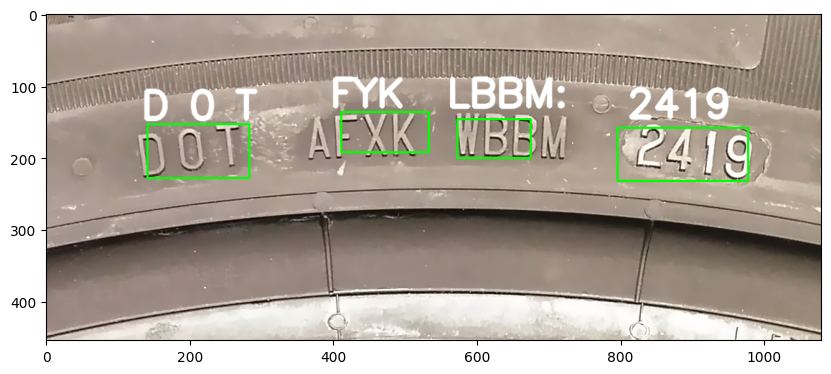

In [41]:
for detection in result : 
    top_left = tuple ( [ int ( val ) for val in detection [ 0 ] [ 0 ] ] )
    bottom_right = tuple ( [ int ( val ) for val in detection [ 0 ] [ 2 ] ] )
    text = detection [ 1 ]
    font = cv2.FONT_HERSHEY_SIMPLEX
    img = cv2.putText ( orig , text , top_left , font , 1.8 , ( 255,255,255 ) , 5 , cv2.LINE_AA )
    plt.figure ( figsize = ( 10,10 ) )
plt.imshow(img)
plt.show ( )